# 20/03/2024
Resnet training for satellite images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import geopandas as gpd
import numpy as np
import seaborn
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

2024-03-26 22:39:32.150930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 22:39:33.605223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-26 22:39:33.605341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-26 22:39:33.605357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
print('TensorFlow version: {}'.format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))

TensorFlow version: 2.11.1
Found GPU at /device:GPU:0


2024-03-26 22:39:34.596292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 22:39:35.355772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 10777 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:05:00.0, compute capability: 3.5


In [4]:
from tensorflow.python.platform import build_info as tf_build_info

tf_build_info.build_info

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.2'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [5]:
!/usr/local/cuda/bin/nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [6]:
cat /usr/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 8
#define CUDNN_MINOR 1
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#endif /* CUDNN_VERSION_H */


In [7]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

libcudnn8:
  Installed: 8.1.0.77-1+cuda11.2
  Candidate: 8.9.7.29-1+cuda12.2
  Version table:
     8.9.7.29-1+cuda12.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.7.29-1+cuda11.8 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.7.29-1+cuda11.8 600
        600 file:/var/cudnn-local-repo-ubuntu2004-8.9.7.29  Packages
     8.9.6.50-1+cuda12.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.6.50-1+cuda11.8 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.5.30-1+cuda12.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.5.30-1+cuda11.8 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.5.29-1+cuda12.2 600
        600 https://dev

In [8]:
# set random seed / make reproducible
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
#load labels to images and observe it
eg_labels = gpd.read_file('../outputs/matched/gauteng-qol-cluster-tiles.geojson')
eg_labels = eg_labels[["tile", "qol_index"]]
print(len(eg_labels))
eg_labels.head()

22150


,tile,qol_index
0,1178-866_14_00.tiff,52.795907
1,1178-866_14_01.tiff,52.795907
2,1178-866_14_02.tiff,52.795907
3,1178-866_14_03.tiff,52.795907
4,1178-866_15_00.tiff,52.795907


<Figure size 1000x600 with 0 Axes>

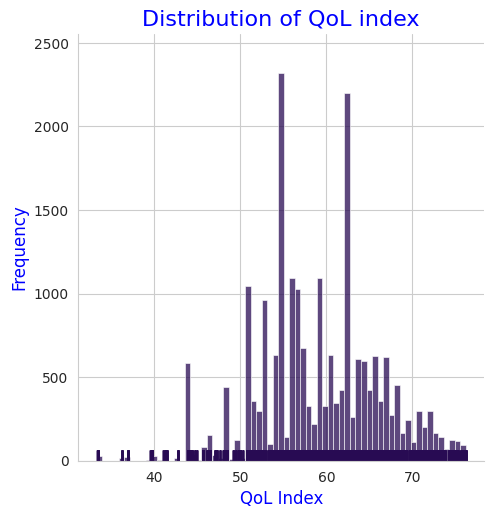

In [10]:
plt.figure(figsize=(10, 6))
seaborn.set_style('whitegrid')
seaborn.set_palette('inferno')
seaborn.displot(eg_labels['qol_index'], rug=True, kde_kws={'fill':True, 'color':'r'})
plt.xlabel('QoL Index', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of QoL index', fontsize=16, color='b')
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# create datagenerator object for training and validation datasets
#rescale images using 1/255
eg_train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
eg_train_datagen_flow = eg_train_datagen.flow_from_dataframe(
    dataframe = eg_labels,
    directory='../outputs/tiles',
    x_col="tile", 
    y_col="qol_index",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(256,256),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=42,
    )

Found 22150 validated image filenames.


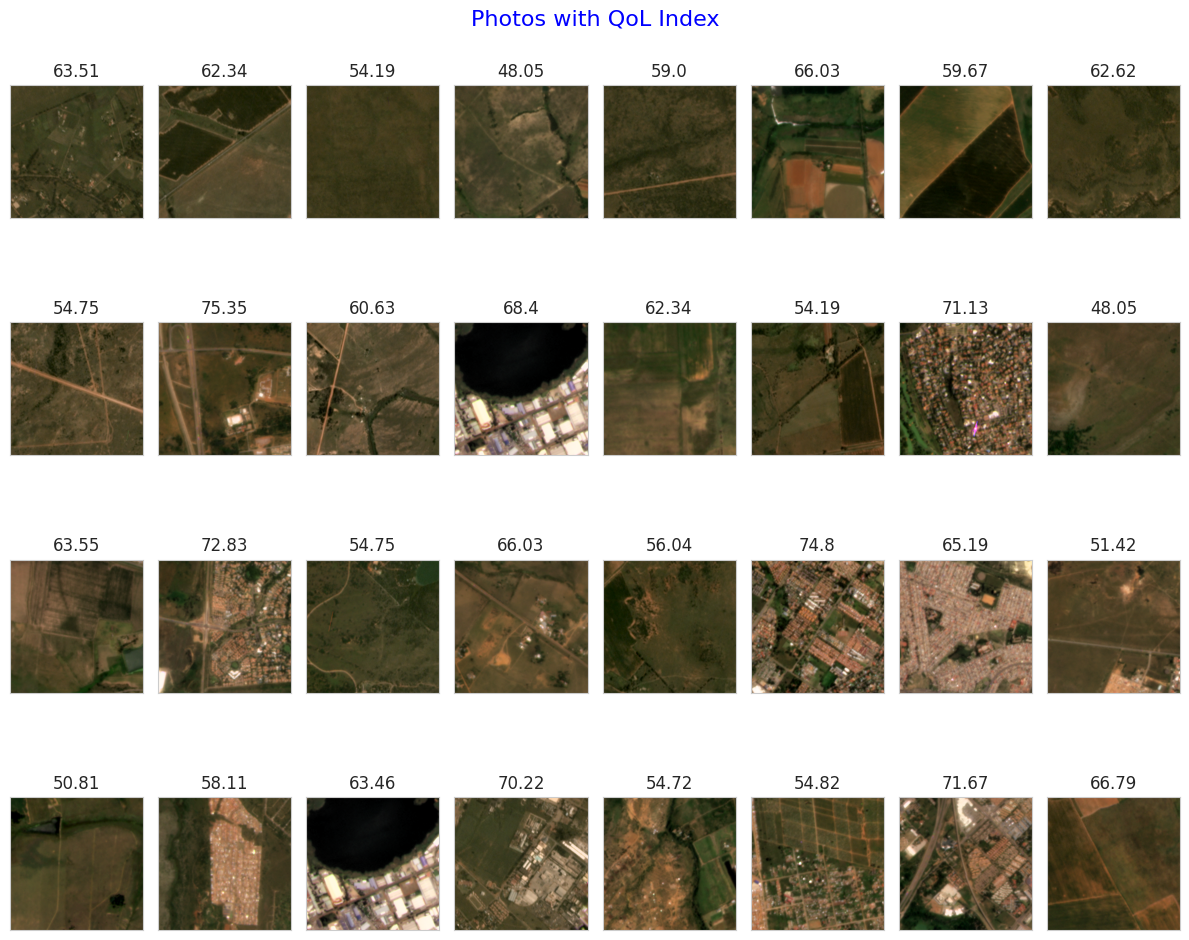

In [12]:
#get one batch from our datagenerator and display images in it
features, target = next(eg_train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{round(target[i], 2)}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with QoL Index',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

## More concrete functions

In [ ]:
# TODO: Train, validation AND TEST
def load_dataset(subset):
    
    """
    Loads the subset (training/validation) of the data from path
    """
    
    labels = gpd.read_file('../outputs/matched/gauteng-qol-cluster-tiles.geojson')
    labels = labels[["tile", "qol_index"]]
    data = ImageDataGenerator(validation_split=0.2, rescale=1 / 255)
    data_flow = data.flow_from_dataframe(
        dataframe=labels,
        directory="../outputs/tiles",
        x_col='tile',
        y_col='qol_index',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset = subset,
        seed=42)

    return data_flow

Could not connect to 127.0.0.1: 54252
Traceback (most recent call last):
  File "C:\Users\emily\AppData\Local\Programs\PyCharm Professional\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_comm.py", line 465, in start_client
    s.connect((host, port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
Traceback (most recent call last):
  File "C:\Users\emily\AppData\Local\Programs\PyCharm Professional\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_utils.py", line 81, in attach_to_debugger
    debugger.connect(pydev_localhost.get_localhost(), debugger_port)
  File "C:\Users\emily\AppData\Local\Programs\PyCharm Professional\plugins\python\helpers\pydev\pydevd.py", line 671, in connect
    s = start_client(host, port)
  File "C:\Users\emily\AppData\Local\Programs\PyCharm Professional\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_comm.py", line 465, in start_client
    s.connect((host, port))
ConnectionRefused

In [14]:

from keras.layers import Dropout, GlobalAveragePooling2D, Dense

def create_model(input_shape):
    
    """
    Defines the model
    """
    # Using ResNet50 architecture - freezing base model
    base_model = ResNet50V2(input_shape=input_shape, weights='imagenet', include_top=False)
    base_model.trainable = False

    # Create new model on top
    # Specify input shape
    inputs = Input(shape=(256, 256, 3))
    
    # New model is base model with training set to false
    x = base_model(inputs, training=False)
    # Add averaging layer to ensure fixed size vector
    x = GlobalAveragePooling2D()(x)
    # Add dropout layer to reduce overfitting
    x = Dropout(0.2)(x)
        
    #final layer, since we are doing regression we will add only one neuron (unit)
    outputs = Dense(1, activation='relu')(x)
    added_model = Model(inputs, outputs)

    print(added_model.summary())

    return base_model, added_model

In [15]:
#load training and testing (actually this is validation data set)
train = load_dataset("training")
validation = load_dataset("validation")

Found 17720 validated image filenames.
Found 4430 validated image filenames.


In [16]:
base_model, model = create_model(input_shape = (256, 256, 3))

2024-03-26 22:40:19.173199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10777 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:05:00.0, compute capability: 3.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [ ]:
model.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
)

In [ ]:
# checkpoint
filepath="../outputs/checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
epochs = 20
print("Fitting the top layer of the model")
# TODO: What does this mean again?
history_a = model.fit(train, epochs=epochs, validation_data=validation, batch_size=10, callbacks=callbacks_list)

Fitting the top layer of the model
Epoch 1/20


2024-03-26 22:40:26.906320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-03-26 22:40:27.183695: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-26 22:40:28.997456: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x556fada719a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 22:40:28.997491: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K40c, Compute Capability 3.5
2024-03-26 22:40:29.003689: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 22:40:29.108599: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-26 22:40:29.182472: I tensorflow/compiler/jit/xla_compilation_cache.cc:4

554/554 [==============================] - 158s 273ms/step - loss: 514.4186 - val_loss: 129.3737
Epoch 2/20
554/554 [==============================] - 148s 267ms/step - loss: 95.9305 - val_loss: 103.1689
Epoch 3/20
554/554 [==============================] - 149s 269ms/step - loss: 76.3849 - val_loss: 95.0024
Epoch 4/20
554/554 [==============================] - 149s 268ms/step - loss: 69.4021 - val_loss: 85.8146
Epoch 5/20
554/554 [==============================] - 149s 268ms/step - loss: 65.4977 - val_loss: 86.0933
Epoch 6/20
554/554 [==============================] - 148s 266ms/step - loss: 62.2832 - val_loss: 86.0975
Epoch 7/20
554/554 [==============================] - 149s 268ms/step - loss: 60.6129 - val_loss: 83.6380
Epoch 8/20
554/554 [==============================] - 149s 268ms/step - loss: 58.7006 - val_loss: 85.0576
Epoch 9/20
554/554 [==============================] - 148s 267ms/step - loss: 57.6382 - val_loss: 83.8556
Epoch 10/20
554/554 [==============================] -

In [18]:
import pandas as pd

<Axes: >

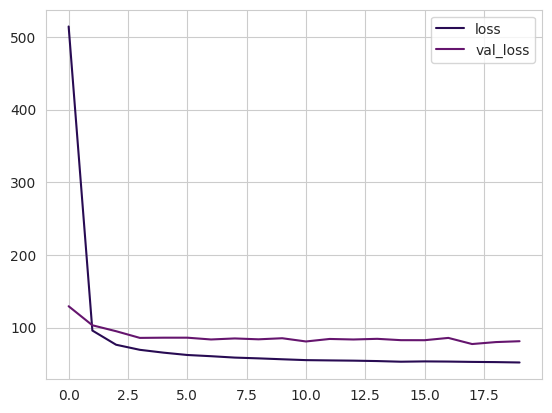

In [19]:
historya_df = pd.DataFrame(history_a.history)
historya_df.loc[0:, ['loss', 'val_loss']].plot()

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss=MeanSquaredError(),
)

epochs = 100
print("Fitting the end-to-end model")
history_b = model.fit(train, epochs=epochs, validation_data=validation)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  Y          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                                            
 dense (Dense)               (None, 1)                 2049      Y          
                                                             

In [ ]:
historyb_df = pd.DataFrame(history_b.history)
historyb_df.loc[0:, ['loss', 'val_loss']].plot()